# Transfer Learning:

In transfer learning, the knowledge of an already trained machine learning model is applied to a different but related problem. For example, if you trained a simple classifier to predict whether an image contains a watch, you could use the knowledge that the model gained during its training to recognize other objects like clock.


#### Pre trained model as Feature Extractor
Remove the last dense layer which is performing classification and use this pre trained model as Feature Extractor.Fixed feature extractor for the new dataset.

For example, if you want to build a self learning car. You can spend years to build a decent image recognition algorithm from scratch or you can take inception model (a pre-trained model) from Google which was built on ImageNet data to identify images in those pictures.


# Dataset Prepration 

In [1]:
import numpy as np
import tensorflow as tf

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

path = "A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset"
dataset_path = os.listdir(path)

print (dataset_path)  #what kinds of classes are in this dataset

print("Types of classes labels found: ", len(dataset_path))

class_labels = []

for item in dataset_path:
 # Get all the file names
 all_classes = os.listdir(path + '/' +item)
 #print(all_classes)

 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))
    #print(class_labels[:5])
    
    
# Build a dataframe        
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
print(df.head())
print(df.tail())

['COVID', 'Normal']
Types of classes labels found:  2
  Labels                              image
0  COVID     dataset_path/COVID/COVID-1.png
1  COVID    dataset_path/COVID/COVID-10.png
2  COVID   dataset_path/COVID/COVID-100.png
3  COVID  dataset_path/COVID/COVID-1000.png
4  COVID  dataset_path/COVID/COVID-1001.png
      Labels                               image
7227  Normal  dataset_path/Normal/Normal-995.png
7228  Normal  dataset_path/Normal/Normal-996.png
7229  Normal  dataset_path/Normal/Normal-997.png
7230  Normal  dataset_path/Normal/Normal-998.png
7231  Normal  dataset_path/Normal/Normal-999.png


In [2]:
# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(df))

label_count = df['Labels'].value_counts()
print(label_count)

Total number of images in the dataset:  7232
Labels
COVID     3616
Normal    3616
Name: count, dtype: int64


In [3]:
import cv2
path = "A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset\\"
dataset_path = os.listdir("A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset")

im_size = 224

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [4]:

#This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. 

images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(7232, 224, 224, 3)

In [5]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df['Labels'].values
#print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
#print (y)

In [6]:

y=y.reshape(-1,1)

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y) #.toarray()
print(Y[:5])
print(Y[35:])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)



(6870, 224, 224, 3)
(6870, 2)
(362, 224, 224, 3)
(362, 2)


## Transfer learning from pre-trained weights

#### Here we initialize the model with pre-trained ImageNet weights,and we fine-tune it on our own dataset.



The first step to transfer learning is to freeze all layers and train only the top layers. For this step, a relatively large learning rate (1e-2) can be used. 

EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

include_top=False means we don't want to use classification layer(Dense from the pretrained network)

In [16]:
import os

# Set parallelism environment variables BEFORE importing TensorFlow
os.environ["TF_INTRA_OP_PARALLELISM_THREADS"] = "4"
os.environ["TF_INTER_OP_PARALLELISM_THREADS"] = "4"
import tensorflow as tf  # Import TensorFlow AFTER setting environment variables

# Verify the settings (DO NOT try to set them again)
print(f"Intra-op threads: {os.environ['TF_INTRA_OP_PARALLELISM_THREADS']}")
print(f"Inter-op threads: {os.environ['TF_INTER_OP_PARALLELISM_THREADS']}")

Intra-op threads: 4
Inter-op threads: 4


In [18]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import tensorflow as tf

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os


NUM_CLASSES = 2
IMG_SIZE = 224



In [19]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [20]:

model = build_model(num_classes=NUM_CLASSES)

In [22]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


#plot_hist(hist)

Epoch 1/20
215/215 - 89s - 414ms/step - accuracy: 0.5277 - loss: 0.7210
Epoch 2/20
215/215 - 81s - 376ms/step - accuracy: 0.5297 - loss: 0.7089
Epoch 3/20
215/215 - 81s - 379ms/step - accuracy: 0.5245 - loss: 0.7088
Epoch 4/20
215/215 - 82s - 380ms/step - accuracy: 0.5249 - loss: 0.7078
Epoch 5/20
215/215 - 81s - 377ms/step - accuracy: 0.5269 - loss: 0.7011
Epoch 6/20
215/215 - 81s - 378ms/step - accuracy: 0.5325 - loss: 0.6964
Epoch 7/20
215/215 - 81s - 379ms/step - accuracy: 0.5249 - loss: 0.6971
Epoch 8/20
215/215 - 82s - 383ms/step - accuracy: 0.5255 - loss: 0.6967
Epoch 9/20
215/215 - 81s - 379ms/step - accuracy: 0.5266 - loss: 0.6963
Epoch 10/20
215/215 - 81s - 378ms/step - accuracy: 0.5237 - loss: 0.6969
Epoch 11/20
215/215 - 82s - 383ms/step - accuracy: 0.5294 - loss: 0.6974
Epoch 12/20
215/215 - 81s - 379ms/step - accuracy: 0.5210 - loss: 0.6992
Epoch 13/20
215/215 - 81s - 378ms/step - accuracy: 0.5255 - loss: 0.6959
Epoch 14/20
215/215 - 82s - 380ms/step - accuracy: 0.5191 - 

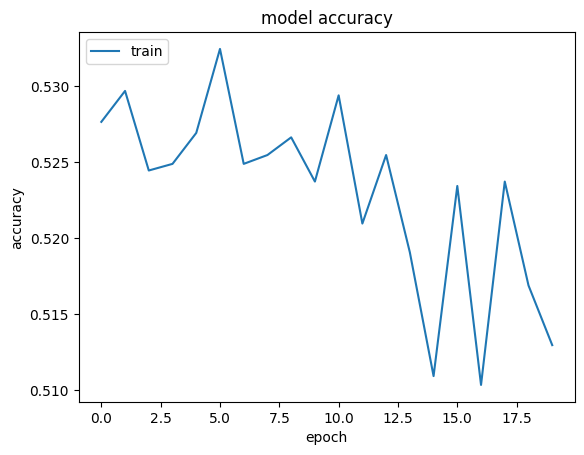

In [28]:
epochs = 20
hist = model.fit(train_x, train_y, epochs=epochs, verbose=2)
plot_hist(hist)

In [29]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - accuracy: 0.4705 - loss: 0.7053
Loss = 0.6958063244819641
Test Accuracy = 0.5027624368667603


c:\Users\malli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_242']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


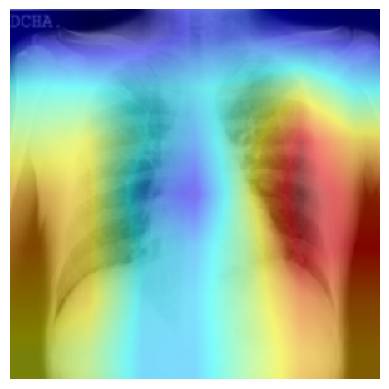

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Load the image
img_path = "A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset\\COVID\\COVID-1000.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make the GradCAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'top_conv')  # Replace 'block7a_project_conv' with the actual name of the last conv layer in your model

# Resize the heatmap to match the original image dimensions
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(cv2.cvtColor(img_array[0].astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

# Save and display the heatmap
cv2.imwrite('heatmap.jpg', superimposed_img)

# Display the image in the notebook
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

c:\Users\malli\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


PartitionExplainer explainer: 2it [00:11, 11.31s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..252.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.450825992191238e-12..1.2762476283580647e-12].


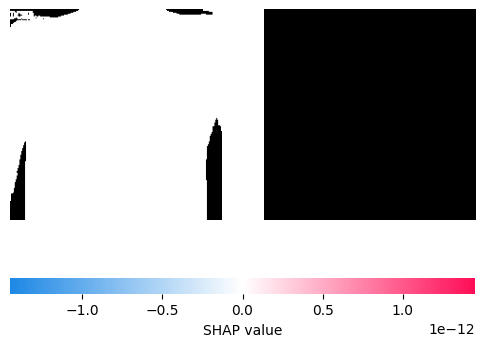

In [26]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img_path = "A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset\\COVID\\COVID-1000.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Define a prediction function
def predict_fn(images):
    return model.predict(images)

# Create a masker
masker = shap.maskers.Image("inpaint_telea", img_array[0].shape)

# Create an explainer
explainer = shap.Explainer(predict_fn, masker)

# Calculate SHAP values
shap_values = explainer(img_array[:1], max_evals=100, batch_size=50)

# Plot the SHAP values
shap.image_plot(shap_values.values, img_array[:1])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  1%|          | 10/1000 [00:00<00:19, 50.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  2%|▏         | 20/1000 [00:00<00:19, 50.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|▎         | 30/1000 [00:00<00:19, 50.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|▍         | 40/1000 [00:00<00:19, 49.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  5%|▌         | 50/1000 [00:01<00:19, 49.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|▌         | 60/1000 [00:01<00:18, 50.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  7%|▋         | 70/1000 [00:01<00:18, 50.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|▊         | 80/1000 [00:01<00:18, 50.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  9%|▉         | 90/1000 [00:01<00:18, 50.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 10%|█         | 100/1000 [00:01<00:17, 50.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 11%|█         | 110/1000 [00:02<00:18, 49.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|█▏        | 120/1000 [00:02<00:17, 49.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 13%|█▎        | 130/1000 [00:02<00:17, 49.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 14%|█▍        | 140/1000 [00:02<00:17, 49.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 15%|█▌        | 150/1000 [00:03<00:17, 49.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 16%|█▌        | 160/1000 [00:03<00:17, 48.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 17%|█▋        | 170/1000 [00:03<00:16, 49.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 18%|█▊        | 180/1000 [00:03<00:16, 49.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 19%|█▉        | 190/1000 [00:03<00:16, 50.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 20%|██        | 200/1000 [00:04<00:16, 49.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|██        | 210/1000 [00:04<00:15, 49.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 22%|██▏       | 220/1000 [00:04<00:15, 50.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 23%|██▎       | 230/1000 [00:04<00:15, 49.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 24%|██▍       | 240/1000 [00:04<00:15, 49.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 25%|██▌       | 250/1000 [00:05<00:15, 49.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 26%|██▌       | 260/1000 [00:05<00:14, 49.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 27%|██▋       | 270/1000 [00:05<00:14, 50.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 28%|██▊       | 280/1000 [00:05<00:14, 49.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 29%|██▉       | 290/1000 [00:05<00:14, 49.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 30%|███       | 300/1000 [00:06<00:13, 50.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 31%|███       | 310/1000 [00:06<00:13, 50.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|███▏      | 320/1000 [00:06<00:13, 49.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|███▎      | 330/1000 [00:06<00:13, 49.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 34%|███▍      | 340/1000 [00:06<00:13, 50.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 35%|███▌      | 350/1000 [00:07<00:13, 49.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███▌      | 360/1000 [00:07<00:12, 50.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 37%|███▋      | 370/1000 [00:07<00:12, 50.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|███▊      | 380/1000 [00:07<00:12, 49.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|███▉      | 390/1000 [00:07<00:12, 50.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 40%|████      | 400/1000 [00:08<00:11, 50.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 41%|████      | 410/1000 [00:08<00:12, 48.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|████▏     | 420/1000 [00:08<00:11, 49.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 43%|████▎     | 430/1000 [00:08<00:11, 49.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 44%|████▍     | 440/1000 [00:08<00:11, 48.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 45%|████▌     | 450/1000 [00:09<00:11, 49.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 46%|████▌     | 460/1000 [00:09<00:10, 49.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 47%|████▋     | 470/1000 [00:09<00:10, 48.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 48%|████▊     | 480/1000 [00:09<00:10, 49.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 49%|████▉     | 490/1000 [00:09<00:10, 49.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 50%|█████     | 500/1000 [00:10<00:10, 48.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 51%|█████     | 510/1000 [00:10<00:09, 49.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|█████▏    | 520/1000 [00:10<00:09, 50.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 53%|█████▎    | 530/1000 [00:10<00:09, 49.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 54%|█████▍    | 540/1000 [00:10<00:09, 49.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 55%|█████▌    | 550/1000 [00:11<00:08, 50.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 56%|█████▌    | 560/1000 [00:11<00:08, 49.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 57%|█████▋    | 570/1000 [00:11<00:08, 49.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 58%|█████▊    | 580/1000 [00:11<00:08, 49.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 59%|█████▉    | 590/1000 [00:11<00:08, 49.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 60%|██████    | 600/1000 [00:12<00:08, 49.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 61%|██████    | 610/1000 [00:12<00:07, 49.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 62%|██████▏   | 620/1000 [00:12<00:07, 48.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 63%|██████▎   | 630/1000 [00:12<00:07, 49.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 64%|██████▍   | 640/1000 [00:12<00:07, 49.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 65%|██████▌   | 650/1000 [00:13<00:07, 49.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 66%|██████▌   | 660/1000 [00:13<00:06, 49.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 67%|██████▋   | 670/1000 [00:13<00:06, 50.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 68%|██████▊   | 680/1000 [00:13<00:06, 49.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|██████▉   | 690/1000 [00:13<00:06, 49.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 70%|███████   | 700/1000 [00:14<00:06, 49.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 71%|███████   | 710/1000 [00:14<00:05, 49.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 72%|███████▏  | 720/1000 [00:14<00:05, 49.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 73%|███████▎  | 730/1000 [00:14<00:05, 49.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 74%|███████▍  | 740/1000 [00:14<00:05, 48.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 75%|███████▌  | 750/1000 [00:15<00:05, 49.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 76%|███████▌  | 760/1000 [00:15<00:04, 49.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 77%|███████▋  | 770/1000 [00:15<00:04, 48.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 78%|███████▊  | 780/1000 [00:15<00:04, 49.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 79%|███████▉  | 790/1000 [00:15<00:04, 49.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 80%|████████  | 800/1000 [00:16<00:04, 48.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 81%|████████  | 810/1000 [00:16<00:03, 49.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 82%|████████▏ | 820/1000 [00:16<00:03, 49.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 83%|████████▎ | 830/1000 [00:16<00:03, 48.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 84%|████████▍ | 840/1000 [00:16<00:03, 49.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 85%|████████▌ | 850/1000 [00:17<00:03, 49.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 86%|████████▌ | 860/1000 [00:17<00:02, 48.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 87%|████████▋ | 870/1000 [00:17<00:02, 49.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 88%|████████▊ | 880/1000 [00:17<00:02, 49.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 89%|████████▉ | 890/1000 [00:17<00:02, 48.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 90%|█████████ | 900/1000 [00:18<00:02, 49.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 91%|█████████ | 910/1000 [00:18<00:01, 49.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 92%|█████████▏| 920/1000 [00:18<00:01, 48.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 93%|█████████▎| 930/1000 [00:18<00:01, 49.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 94%|█████████▍| 940/1000 [00:18<00:01, 48.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 95%|█████████▌| 950/1000 [00:19<00:01, 46.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 96%|█████████▌| 960/1000 [00:19<00:00, 47.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 97%|█████████▋| 970/1000 [00:19<00:00, 47.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 98%|█████████▊| 980/1000 [00:19<00:00, 46.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 99%|█████████▉| 990/1000 [00:20<00:00, 47.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


100%|██████████| 1000/1000 [00:20<00:00, 49.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..126.5].


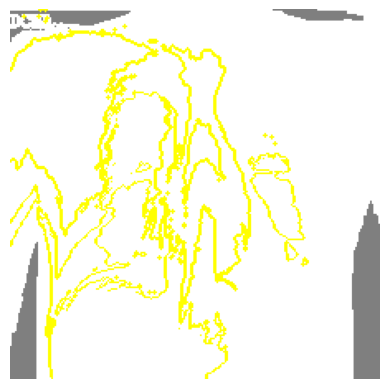

In [27]:
import lime
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Load the image
img_path = "A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset\\COVID\\COVID-1000.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Define the prediction function
def predict_fn(images):
    return model.predict(images)

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(img_array[0].astype('double'), predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Show the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()